In [4]:
import sys
import os
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import pickle

import gensim
import multiprocessing

from gensim.models import ldaseqmodel
from gensim import corpora, utils
from gensim.matutils import hellinger

from gensim.models import CoherenceModel

In [5]:
# unpack data file

with open ('../data/data_list_bert', 'rb') as fp:
    itemlist = pickle.load(fp)
    
df, documents, dictionary, corpus = itemlist  

# Make a index to word dictionary.
id2word = dictionary.id2token

In [6]:
df.head()

,title,abstract,title_abstract,journal,year,bert,bert_filtered
0,Psychiatric-Related Revisits to the Emergency ...,OBJECTIVES: Repeat visits (revisits) to Emerge...,psychiatric related revisits emergency departm...,Academic Emergency Medicine,2019,psychiatric related revisit emergency departme...,psychiatric related revisit follow rapid expan...
1,"Synergistic Bradycardia from Beta Blockers, Hy...",BACKGROUND: Bradycardia is a common vital sign...,"synergistic bradycardia beta blockers, hyperka...",Journal of Emergency Medicine,2019,synergistic bradycardia beta blocker hyperkale...,bradycardia beta blocker hyperkalemia renal fa...
2,Lack of fetal effect from adenosine administra...,Supraventricular Tachycardias are the most com...,lack fetal effect adenosine administration pre...,American Journal of Emergency Medicine,2019,lack fetal effect adenosine administration pre...,lack fetal effect adenosine administration pre...
3,Comparing intranasal ketamine with intravenous...,BACKGROUND: Kidney stones are a fairly common ...,comparing intranasal ketamine intravenous fent...,American Journal of Emergency Medicine,2019,compare intranasal ketamine intravenous fentan...,compare intranasal ketamine intravenous fentan...
4,Involuntary patient length-of-stay at a suburb...,BACKGROUND: Patients who may be a danger to th...,involuntary patient length of stay suburban em...,American Journal of Emergency Medicine,2019,involuntary patient length stay suburban emerg...,involuntary length stay suburban background da...


In [12]:
test1 = df['bert_filtered'].tolist()
test1[0]

'psychiatric related revisit follow rapid expansion community mental health service repeat visit revisit ed psychiatric reflect poor continuity impose high financial cost test rapid expansion community health center provide regional low cost primary correspond few repeat psychiatric related visit'

In [13]:
from bert_serving.client import BertClient
bc = BertClient()
doc_vecs = bc.encode(test1)

In [14]:
type(doc_vecs)

numpy.ndarray

In [15]:
doc_vecs.shape

(20528, 768)

In [18]:

with open('../data/bert_doc_vecs', 'wb') as fp:
    pickle.dump(doc_vecs, fp)

In [42]:
import umap
d = 0.01
n = 100
reducer = umap.UMAP(min_dist = d, n_neighbors = n, random_state=42)

In [33]:
import numpy as np
from sklearn.preprocessing import normalize

norm_doc =  doc_vecs / np.linalg.norm(doc_vecs)

In [34]:
norm_doc.shape

(20528, 768)

In [43]:
# Embed with UMAP
embedding = reducer.fit_transform(norm_doc)
embedding.shape

(20528, 2)

In [38]:
norm_doc[0]

array([-2.15745749e-05,  1.01508420e-04, -3.39933445e-06,  9.89202890e-05,
        4.78609945e-05, -9.14326156e-05, -7.75101435e-05, -2.62336780e-05,
       -9.70350375e-05,  6.73829709e-05,  5.32711019e-05,  4.20058532e-05,
        1.97180809e-04,  9.42561292e-06, -5.90124000e-06,  5.42793496e-05,
       -1.01136102e-04, -4.77301910e-05, -1.05458341e-04,  2.98158393e-05,
        5.19152491e-05, -1.41488767e-04, -9.01545427e-05, -2.24221149e-05,
       -3.93704722e-05, -2.82739911e-05, -3.05919602e-05,  2.86446564e-04,
        9.45103675e-05,  4.31878943e-05,  5.52454694e-05,  5.21054535e-05,
       -9.05816996e-05,  2.56200237e-05, -1.83649870e-04,  1.52428329e-05,
        1.38465975e-06,  3.45186781e-05, -6.44473112e-05,  6.42314553e-05,
        6.66870756e-06, -3.45153749e-05,  2.79370561e-05, -2.08257290e-04,
        4.02333353e-05,  1.35119684e-04,  8.34774910e-05, -3.73051444e-05,
        5.52600395e-05, -3.93544433e-05,  2.89896852e-04, -5.49102442e-05,
        4.85129676e-05, -

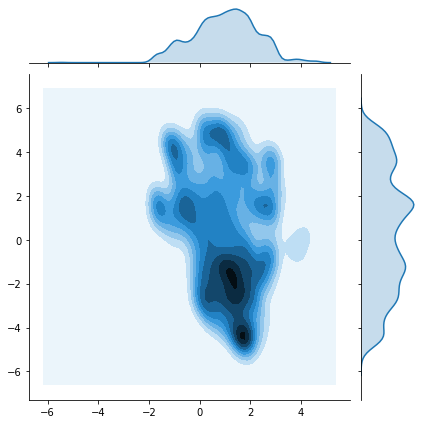

In [44]:
sns.jointplot(x=embedding[:,0], y=embedding[:,1], kind='kde', nlevels=20)

In [45]:
from sklearn import mixture
import numpy as np

def GMM(embedding,n_clust):
    gmm = mixture.GaussianMixture(n_components=n_clust, random_state=42, covariance_type="full")
    gmm.fit(embedding)
    return gmm.predict(embedding), gmm
    
    
def plot_GMM(embedding, y):
    f, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], s= .01, c=y, cmap='Spectral')
    plt.colorbar()

def cluster_center_calc(embedding, gmm_model): 
    cent = []
    gmm_clusters = gmm_model.predict(embedding)
    for c in np.unique(gmm_clusters):
        cent.append(np.median(embedding[gmm_clusters == c,:], axis = 0))
    return cent    
    
def cluster_center(embedding,gmm_model):
    centers = []
    gmm_clusters = gmm_model.predict(embedding)
    for c in np.unique(gmm_clusters):
        centers.append(np.mean(embedding[gmm_clusters == c,:], axis = 0))
    return centers

def plot_GMM_centers(embedding, y, centers):
    f, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], s= .01, c=y, cmap='Spectral')
    plt.axis('off')
    i = 0
    for c in centers:
        plt.text(c[0], c[1], i, fontsize=16)
        i = i+1

In [49]:
n_clust = 20
gmm_clusters, gmm_model = GMM(embedding,n_clust)
centers = cluster_center_calc(embedding, gmm_model)
threshold_clust = np.where(np.bincount(gmm_clusters) > 200)[0]

In [50]:
threshold_clust

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [55]:
gmm_clusters.shape

(20528,)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


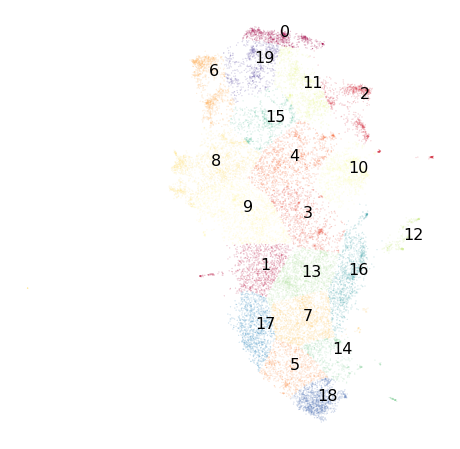

In [51]:
plot_GMM_centers(embedding,gmm_clusters,centers)
print(threshold_clust)